In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from numpy.linalg import matrix_power 
import scipy.linalg
from cca import ComplexityComponentsAnalysis

In [2]:
def oscillators_dynamics_mat(N=10, omega_sq=.1, alpha_sq=.2, gamma=.05, tau=1.):
    #spring matrix K
    K = np.zeros((N, N))
    K += np.eye(N) * (0.5*omega_sq + alpha_sq)
    K[1:, :-1] += np.eye(N-1) * (-0.5*alpha_sq) #lower diag
    K[:-1, 1:] += np.eye(N-1) * (-0.5*alpha_sq) #upper diag
    K[0, -1] = -0.5*alpha_sq
    K[-1, 0] = -0.5*alpha_sq
    #friction matrix gamma
    gamma_mat = gamma * np.eye(N)
    #continuous-time dynamics matrix B (z^dot = B * z)
    B_top = np.concatenate((np.zeros((N, N)), np.eye(N)), axis=1)
    B_bottom = np.concatenate((-K, -gamma_mat), axis=1)
    B = np.concatenate((B_top, B_bottom), axis=0)
    #discrete-time dynamics matrix A (z_t = A * z_{t-1})
    A = expm(B * tau)
    return A

def oscillators_cross_cov_mats(A, T=10, sigma=1.):
    #get N
    N = A.shape[0] // 2
    #noise matrix sigma (just position noise)
    sigma_mat = np.zeros((2*N, 2*N))
    sigma_mat[:N, :N] = np.eye(N) * sigma**2
    #steady-state covariance matrix C
    C = np.ones(2*N)
    for i in range(100000):
        C = A.dot(C).dot(A.T) + sigma_mat
    #function for generating cross-cov matrices <z_{t+k} z_t^T>
    def gen_cross_cov(k):
        A_k = matrix_power(A, k)
        A_k_C = A_k.dot(C)
        return A_k_C
    #make all cross_cov mats for delta t = {0, .., T-1}
    cross_cov_mats = np.array([gen_cross_cov(k) for k in range(T)])
    return cross_cov_mats


def sample_oscillators(A, T, sigma=1.):
    #generate sample of dynamics
    N = A.shape[0] // 2
    z = np.zeros((T, 2*N))
    for i in range(1, T):
        z[i] = np.dot(A, z[i - 1])
        z[i, :N] += np.random.normal(0, sigma, N) #only position noise
    return z

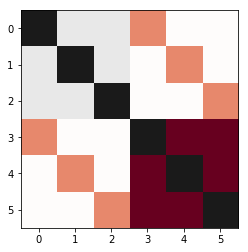

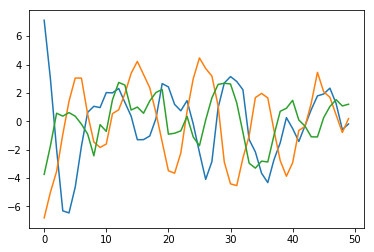

In [3]:
A = oscillators_dynamics_mat(N=3)
cross_cov_mats = oscillators_cross_cov_mats(A, T=11)
plt.imshow(cross_cov_mats[0], vmin=-1, vmax=1, cmap="RdGy")
plt.show()

z = sample_oscillators(A, 1000)
plt.plot(z[500:550, :3])

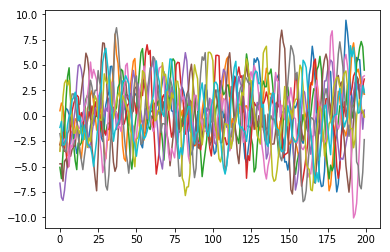

In [3]:
#generate sample of dynamics

T_sample = 1000
z = np.zeros((T_sample, 2*N))
for i in range(1, T_sample):
    z[i] = np.dot(A, z[i - 1])
    z[i] += np.random.multivariate_normal(mean=np.zeros(2*N), cov=sigma)
    
plt.plot(z[500:700, :N])

In [5]:
#CCA

cov = gen_cross_cov(0)
cross_cov = gen_cross_cov(10).T

def cca_proj(cov_11, cov_12):
    w = scipy.linalg.eigvalsh(cov_11)
    min_eig = np.min(w)
    eps = 1e-8
    if min_eig < eps:
        cov_11 = cov_11 + np.eye(cov_11.shape[0])*(-min_eig + eps)
    cov_neg_sqrt = np.real(np.linalg.inv(scipy.linalg.sqrtm(cov_11)))
    to_svd = cov_neg_sqrt.dot(cov_12).dot(cov_neg_sqrt)
    U, s, Vt = scipy.linalg.svd(to_svd)
    V = Vt.T
    U = np.dot(cov_neg_sqrt, U)
    V = np.dot(cov_neg_sqrt, V)
    U /= np.sqrt(np.sum(U**2, axis=0))
    V /= np.sqrt(np.sum(V**2, axis=0))
    return U, V

def sfa_proj(cov_11, cov_12):
    w = scipy.linalg.eigvalsh(cov_11)
    min_eig = np.min(w)
    eps = 1e-8
    if min_eig < eps:
        cov_11 = cov_11 + np.eye(cov_11.shape[0])*(-min_eig + eps)
    cov_neg_sqrt = np.real(np.linalg.inv(scipy.linalg.sqrtm(cov_11)))
    cov_sym = cov_12 + cov_12.T
    to_pca = cov_neg_sqrt.dot(cov_sym).dot(cov_neg_sqrt)
    _, V = scipy.linalg.eigh(to_pca)
    V = V[:, ::-1]
    V = np.dot(cov_neg_sqrt, V)
    return V

def pca_proj(cov):
    """
    corr = np.zeros_like(cov)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[0]):
            corr[i, j] = cov[i, j]/np.sqrt(cov[i, i]*cov[j, j])
    """
    _, V = scipy.linalg.eigh(cov)
    V = V[:, ::-1]
    return V

def dca_proj(cov_11, cov_12, d, n_init=1):
    opt = ComplexityComponentsAnalysis(init="random")
    opt.cross_covs = np.array([cov_11, cov_12.T])
    opt.fit_projection(d=d, n_init=n_init)
    V = opt.coef_
    return V

def quad_mat(A, B, C, D):
    top = np.concatenate((A, B), axis=1)
    bottom = np.concatenate((C, D), axis=1)
    mat = np.concatenate((top, bottom), axis=0)
    return mat

def calc_pi(cov_11, cov_12, U, V):
    proj_cov_11 = U.T.dot(cov_11).dot(U)
    proj_cov_22 = V.T.dot(cov_11).dot(V)
    proj_cov_12 = U.T.dot(cov_12).dot(V)
    proj_cov_21 = proj_cov_12.T
    cov_full = quad_mat(proj_cov_11, proj_cov_12, proj_cov_21, proj_cov_22)
    d1 = np.linalg.slogdet(proj_cov_11)[1]
    d2 = np.linalg.slogdet(proj_cov_22)[1]
    d3 = np.linalg.slogdet(cov_full)[1]
    return 0.5 * (d1 + d2 - d3) / np.log(2)

U_cca, V_cca = cca_proj(cov, cross_cov.T)
V_pca = pca_proj(cov)
V_sfa = sfa_proj(cov, cross_cov.T)
V_trunc = np.eye(cov.shape[0])[:, ::-1]

cca_pi_vals = []
dca_pi_vals = []
pca_pi_vals = []
sfa_pi_vals = []
trunc_pi_vals = []
dumb_cca_pi_vals = []


for i in range(1, 2*N + 1):
    print(i)
    pi_cca = calc_pi(cov, cross_cov.T, U_cca[:, :i], V_cca[:, :i])
    cca_pi_vals.append(pi_cca)
    
    V_dca = dca_proj(cov, cross_cov.T, i, n_init=1)
    pi_dca = calc_pi(cov, cross_cov.T, V_dca, V_dca)
    dca_pi_vals.append(pi_dca)
    
    pi_pca = calc_pi(cov,  cross_cov.T, V_pca[:, :i], V_pca[:, :i])
    pca_pi_vals.append(pi_pca)
    
    pi_sfa = calc_pi(cov, cross_cov.T, V_sfa[:, :i], V_sfa[:, :i])
    sfa_pi_vals.append(pi_sfa)
    
    pi_trunc = calc_pi(cov, cross_cov.T, V_trunc[:, :i], V_trunc[:, :i])
    trunc_pi_vals.append(pi_trunc)
    
    pi_dumb_cca = calc_pi(cov, cross_cov.T, U_cca[:, :i], U_cca[:, :i])
    dumb_cca_pi_vals.append(pi_dumb_cca)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


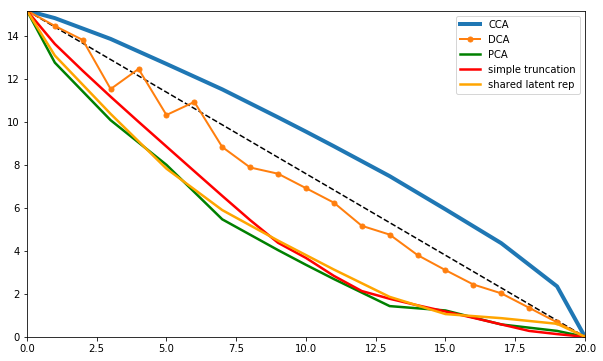

In [7]:
pi_max = calc_pi(cov, cross_cov.T, np.eye(cov.shape[0]), np.eye(cov.shape[0]))
slope = pi_max / (2*N)
x = np.arange(2*N + 1)

fig, ax = plt.subplots(1, 1, figsize=(5*2, 3*2))
ax.plot(x, pi_max - slope*x, c="black", linestyle="--")
ax.plot(cca_pi_vals[::-1] + [0], linewidth=4, label="CCA")
ax.plot(dca_pi_vals[::-1] + [0], linewidth=2, marker=".", markersize=10, label="DCA")
ax.plot(pca_pi_vals[::-1] + [0], linewidth=2.5, label="PCA", c="green")
#ax.plot(sfa_pi_vals[::-1] + [0], linewidth=2.5, label="SFA")
ax.plot(trunc_pi_vals[::-1] + [0], linewidth=2.5, label="simple truncation", c="red")
ax.plot(dumb_cca_pi_vals[::-1] + [0], linewidth=2.5, label="shared latent rep", c="orange")
ax.set_xlim([0, 2*N])
ax.set_ylim([0, pi_max])

ax.legend()

In [249]:
pi_max

15.182515701860659

In [74]:
K

array([[ 0.205, -0.1  ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   , -0.1  ],
       [-0.1  ,  0.205, -0.1  ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.205, -0.1  ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   , -0.1  ,  0.205, -0.1  ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.1  ,  0.205, -0.1  ,  0.   ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   , -0.1  ,  0.205, -0.1  ,  0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.1  ,  0.205, -0.1  ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.1  ,  0.205,
        -0.1  ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.1  ,
         0.205, -0.1  ],
       [-0.1  ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        -0.1  ,  0.205]])